## Folder (for Custom Datasets)

Here we show how one can utilize custom datasets to train anomalib models. A custom dataset in this model can be of the following types:

- A dataset with good and bad images.
- A dataset with good and bad images as well as mask ground-truths for pixel-wise evaluation.
- A dataset with good and bad images that is already split into training and testing sets.

To experiment this setting we provide a toy dataset that could be downloaded from the following [https://github.com/openvinotoolkit/anomalib/blob/main/docs/source/data/hazelnut_toy.zip](link). For the rest of the tutorial, we assume that the dataset is downloaded and extracted to `../../datasets`, located in the `anomalib` directory.

In [ ]:
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data.folder import Folder, FolderDataset
from anomalib.pre_processing import PreProcessor
from anomalib.pre_processing.transforms import Denormalize

### Torch Dataset

In [ ]:
FolderDataset??

To create `FolderDataset` we need to import `pre_process` that applies transforms to the input image.

In [ ]:
PreProcessor??

In [3]:
pre_process = PreProcessor(image_size=256, to_tensor=True)

#### Classification Task

In [4]:
folder_dataset_classification_train = FolderDataset(
    normal_dir="../../datasets/hazelnut_toy/good",
    abnormal_dir="../../datasets/hazelnut_toy/crack",
    split="train",
    pre_process=pre_process,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,split
0,../../datasets/hazelnut_toy/good/08.jpg,normal,0,train
1,../../datasets/hazelnut_toy/good/30.jpg,normal,0,train
2,../../datasets/hazelnut_toy/good/09.jpg,normal,0,train
3,../../datasets/hazelnut_toy/good/25.jpg,normal,0,train
4,../../datasets/hazelnut_toy/good/26.jpg,normal,0,train


Let's look at the first sample in the dataset.

In [5]:
data = folder_dataset_classification_train[0]
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([3, 256, 256]))

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task

In [6]:
# Folder Classification Test Set
folder_dataset_classification_train = FolderDataset(
    normal_dir="../../datasets/hazelnut_toy/good",
    abnormal_dir="../../datasets/hazelnut_toy/crack",
    split="test",
    pre_process=pre_process,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,split
0,../../datasets/hazelnut_toy/good/33.jpg,normal,0,test
1,../../datasets/hazelnut_toy/good/25.jpg,normal,0,test
2,../../datasets/hazelnut_toy/good/01.jpg,normal,0,test
3,../../datasets/hazelnut_toy/good/02.jpg,normal,0,test
4,../../datasets/hazelnut_toy/good/03.jpg,normal,0,test


In [7]:
data = folder_dataset_classification_train[0]
data.keys(), data["image"].shape, data["image_path"], data["label"]

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([3, 256, 256]),
 '../../datasets/hazelnut_toy/good/33.jpg',
 0)

#### Segmentation Task

It is also possible to configure the Folder dataset for the segmentation task, where the dataset object returns image and ground-truth mask.

In [8]:
# Folder Segmentation Train Set
folder_dataset_segmentation_train = FolderDataset(
    normal_dir="../../datasets/hazelnut_toy/good",
    abnormal_dir="../../datasets/hazelnut_toy/crack",
    split="train",
    pre_process=pre_process,
    mask_dir="../../datasets/hazelnut_toy/mask/crack",
)
folder_dataset_segmentation_train.samples.head()

,image_path,label,label_index,mask_path,split
0,../../datasets/hazelnut_toy/good/08.jpg,normal,0,,train
1,../../datasets/hazelnut_toy/good/33.jpg,normal,0,,train
2,../../datasets/hazelnut_toy/good/30.jpg,normal,0,,train
3,../../datasets/hazelnut_toy/good/09.jpg,normal,0,,train
4,../../datasets/hazelnut_toy/good/26.jpg,normal,0,,train


In [9]:
# Folder Segmentation Test Set
folder_dataset_segmentation_test = FolderDataset(
    normal_dir="../../datasets/hazelnut_toy/good",
    abnormal_dir="../../datasets/hazelnut_toy/crack",
    split="test",
    pre_process=pre_process,
    mask_dir="../../datasets/hazelnut_toy/mask/crack",
    task="segmentation",
)
folder_dataset_segmentation_test.samples.head(10)

,image_path,label,label_index,mask_path,split
0,../../datasets/hazelnut_toy/good/14.jpg,normal,0,,test
1,../../datasets/hazelnut_toy/good/10.jpg,normal,0,,test
2,../../datasets/hazelnut_toy/good/29.jpg,normal,0,,test
3,../../datasets/hazelnut_toy/good/06.jpg,normal,0,,test
4,../../datasets/hazelnut_toy/good/27.jpg,normal,0,,test
5,../../datasets/hazelnut_toy/good/32.jpg,normal,0,,test
6,../../datasets/hazelnut_toy/crack/01.jpg,abnormal,1,../../datasets/hazelnut_toy/mask/crack/01.jpg,test
7,../../datasets/hazelnut_toy/crack/02.jpg,abnormal,1,../../datasets/hazelnut_toy/mask/crack/02.jpg,test
8,../../datasets/hazelnut_toy/crack/04.jpg,abnormal,1,../../datasets/hazelnut_toy/mask/crack/04.jpg,test
9,../../datasets/hazelnut_toy/crack/03.jpg,abnormal,1,../../datasets/hazelnut_toy/mask/crack/03.jpg,test


In [10]:
data = folder_dataset_segmentation_test[9]
data.keys(), data["image"].shape, data["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([3, 256, 256]),
 torch.Size([256, 256]))

Let's visualize the image and the mask...

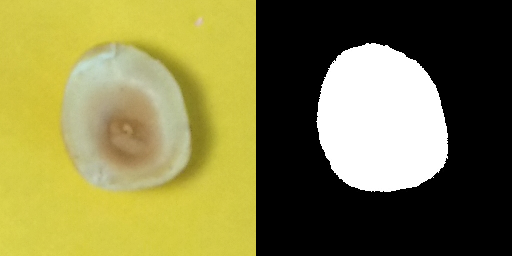

In [11]:
img = ToPILImage()(Denormalize()(data["image"].clone()))
msk = ToPILImage()(data["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

### DataModule

So far, we have shown the Torch Dataset implementation of Folder dataset. This is quite useful to get a sample. However, when we train models end-to-end fashion, we do need much more than this such as downloading the dataset, creating train/val/test/inference dataloaders. To handle all these, we have the PyTorch Lightning DataModule implementation, which is shown below

In [12]:
folder_datamodule = Folder(
    root="../../datasets/hazelnut_toy/",
    normal_dir="good",
    abnormal_dir="crack",
    task="segmentation",
    mask_dir="../../datasets/hazelnut_toy/mask/crack",
    image_size=256,
)
folder_datamodule.setup()

In [13]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([28, 3, 256, 256]))

In [14]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([11, 3, 256, 256]),
 torch.Size([11, 256, 256]))

As can be seen above, creating the dataloaders are pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.

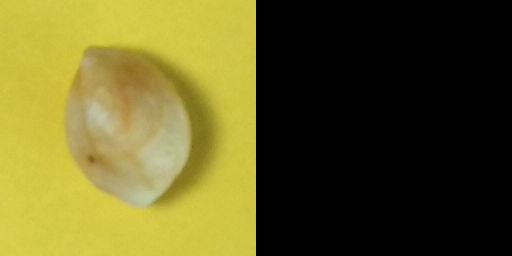

In [15]:
img = ToPILImage()(Denormalize()(data["image"][0].clone()))
msk = ToPILImage()(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.